
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 線形回帰の簡潔な実装

:label: `sec_linear_concise`

過去 10 年間、ディープラーニングはカンブリア紀の爆発のような現象を目撃してきました。技術、アプリケーション、アルゴリズムの膨大な数は、過去数十年の進歩をはるかに上回っています。これは複数の要因の偶然の組み合わせによるもので、その 1 つは多くのオープンソースの深層学習フレームワークが提供する強力な無料ツールです。 Theano :cite: `Bergstra.Breuleux.Bastien.ea.2010` 、DistBelief :cite: `Dean.Corrado.Monga.ea.2012` 、および Caffe :cite: `Jia.Shelhamer.Donahue.ea.2014`はおそらくそのようなモデルの第一世代を表します。それは広く採用されました。 Lisp のようなプログラミング体験を提供した SN2 (Simulateur Neuristique) :cite: `Bottou.Le-Cun.1988`のような初期の (独創的な) 作品とは対照的に、最新のフレームワークは自動微分と Python の利便性を提供します。これらのフレームワークを使用すると、勾配ベースの学習アルゴリズムを実装する反復作業を自動化およびモジュール化できます。

 :numref: `sec_linear_scratch`では、(i) データ ストレージと線形代数のテンソルのみに依存しました。 (ii) 勾配を計算するための自動微分。実際には、データ反復子、損失関数、オプティマイザー、ニューラル ネットワーク層は非常に一般的であるため、最新のライブラリでもこれらのコンポーネントが実装されています。このセクションでは、深層学習フレームワークの :numref: `sec_linear_scratch`から (**高レベルの API を使用して簡潔に**)**線形回帰モデルを実装する方法を示します**。


In [1]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l


## モデルの定義

:numref: `sec_linear_scratch`で線形回帰を最初から実装したとき、モデル パラメーターを明示的に定義し、基本的な線形代数演算を使用して出力を生成する計算をコード化しました。これを行う方法を知っておく*必要があります*。しかし、モデルがより複雑になり、これをほぼ毎日実行する必要がある場合は、喜んで支援するでしょう。この状況は、自分のブログを最初からコーディングするのと似ています。 1 回か 2 回実行するのはやりがいがあり、有益ですが、車輪の再発明に 1 か月も費やしていたら、ひどい Web 開発者になってしまいます。

標準的な操作の場合、[**フレームワークの事前定義されたレイヤーを使用する**] ことができます。これにより、実装について心配するのではなく、モデルの構築に使用されるレイヤーに集中できるようになります。 :numref: `fig_single_neuron`で説明されている単層ネットワークのアーキテクチャを思い出してください。この層は、行列とベクトルの乗算によって各入力が各出力に接続されるため、*完全接続と*呼ばれます。



PyTorch では、完全に接続された層は`Linear`と`LazyLinear` (バージョン 1.8.0 以降で利用可能) クラスで定義されます。後者では、ユーザーは出力次元*のみ*を指定できますが、前者では、この層に入力される入力の数も追加で要求されます。入力形状の指定は不便であり、(畳み込み層などで) 自明ではない計算が必要になる場合があります。したがって、簡単にするために、可能な限りそのような「遅延」レイヤーを使用します。


In [2]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)


`forward`メソッドでは、事前定義されたレイヤーの組み込み`__call__`メソッドを呼び出して出力を計算するだけです。


In [3]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)


## 損失関数の定義



[ **`MSELoss`クラスは平均二乗誤差を計算します ( :eqref: `eq_mse`の $1/2$ 要素なし)。** ] デフォルトでは、 `MSELoss`サンプル全体の平均損失を返します。独自のものを実装するよりも速く (そして使いやすく) なります。


In [4]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)


## 最適化アルゴリズムの定義



Minibatch SGD はニューラル ネットワークを最適化するための標準ツールであるため、PyTorch は`optim`モジュールでこのアルゴリズムのさまざまなバリエーションとともに Minibatch SGD をサポートしています。 ( **`SGD`インスタンスをインスタンス化する**) ときは、 `self.parameters()`を介してモデルから取得できる最適化するパラメータと、最適化アルゴリズムに必要な学習率 ( `self.lr` ) を指定します。


In [5]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)


## トレーニング

深層学習フレームワークの高レベル API を使用してモデルを表現すると、必要なコード行が少なくなっていることに気づいたかもしれません。パラメーターを個別に割り当てたり、損失関数を定義したり、ミニバッチ SGD を実装したりする必要はありません。より複雑なモデルを扱い始めると、高レベル API の利点が大幅に増大します。これで基本的な部分がすべて整いました。 [**トレーニング ループ自体は、最初から実装したものと同じです。** ] したがって、モデルをトレーニングするには、 :numref: `sec_linear_scratch`の`fit_epoch`メソッドの実装に依存する`fit`メソッド ( :numref: `oo-design-training`で導入) を呼び出すだけです。


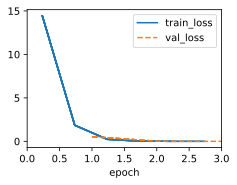

In [6]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)


以下では、[**有限データでのトレーニングによって学習されたモデル パラメーターと、データセットを生成した実際のパラメーターを比較**] します。パラメーターにアクセスするには、必要なレイヤーの重みとバイアスにアクセスします。スクラッチからの実装と同様に、推定されたパラメータが実際のパラメータに近いことに注意してください。


In [7]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

In [8]:
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0022, -0.0069])
error in estimating b: tensor([0.0080])



## まとめ

このセクションには、MXNet :cite: `Chen.Li.Li.ea.2015` 、 JAX :cite: `Frostig.Johnson.Leary.2018`などの最新のディープ ラーニング フレームワークによって提供される利便性を活用するためのディープ ネットワーク (本書内) の最初の実装が含まれています。 `Frostig.Johnson.Leary.2018` 、PyTorch :cite: `Paszke.Gross.Massa.ea.2019` 、および Tensorflow :cite: `Abadi.Barham.Chen.ea.2016` 。データの読み込み、レイヤー、損失関数、オプティマイザー、トレーニング ループの定義にはフレームワークのデフォルトを使用しました。これらのコンポーネントのライブラリ実装はパフォーマンスのために大幅に最適化され、信頼性について適切にテストされる傾向があるため、フレームワークが必要なすべての機能を提供する場合は、通常、それらを使用することをお勧めします。同時に、これらのモジュールは直接実装*できること*を忘れないようにしてください。これは、現在のライブラリに存在する可能性のない新しいコンポーネントを発明するモデル開発の最前線で生きたいと考えている意欲的な研究者にとって特に重要です。



PyTorch では、 `data`モジュールはデータ処理用のツールを提供し、 `nn`モジュールは多数のニューラル ネットワーク層と共通の損失関数を定義します。パラメーターの値を`_`で終わるメソッドに置き換えることで、パラメーターを初期化できます。ネットワークの入力ディメンションを指定する必要があることに注意してください。今のところこれは些細なことですが、多くの層を持つ複雑なネットワークを設計する場合には、重大な波及効果が生じる可能性があります。移植性を実現するには、これらのネットワークをパラメータ化する方法を慎重に検討する必要があります。



## 演習
1. ミニバッチ全体の損失の合計をミニバッチの損失の平均に置き換える場合、学習率をどのように変更する必要があるでしょうか?
1. どの損失関数が提供されているかを確認するには、フレームワークのドキュメントを参照してください。特に、二乗損失を Huber の堅牢な損失関数に置き換えます。つまり、損失関数 $$l(y,y&#39;) = \begin{cases}|y-y&#39;| を使用します。 -\frac{\sigma}{2} &amp; \text{ if } |y-y&#39;| &gt; \sigma \ \frac{1}{2 \sigma} (y-y&#39;)^2 &amp; \text{ それ以外の場合}\end{cases}$$
1. モデルの重みの勾配にどのようにアクセスしますか?
1. 学習率とエポック数を変更すると、解はどのように変化しますか?改善は続いていますか?
1. 生成されるデータの量を変更すると、ソリューションはどのように変化しますか?<ol><li> $\hat{\mathbf{w}} - \mathbf{w}$ および $\hat{b} - b$ の推定誤差をデータ量の関数としてプロットします。ヒント: データ量は、線形ではなく対数的に増加します。つまり、1,000、2,000、...、10,000 ではなく、5、10、20、50、...、10,000 と増加します。
1. ヒント内の提案が適切であるのはなぜですか?



[ディスカッション](https://discuss.d2l.ai/t/45)
